## 三、追踪列车优化（独立优化）

In [1]:
"""
~ train coordinative operation optimization
~ decision variable: 
    - switch points of train2, meaning unilateral coordination
    - or the control regimes sequence of train1 and train2

"""
import sys
sys.path.append("D:\Python\Jupyter_Code")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy
from datetime import datetime
from scipy.integrate import odeint
from scipy.interpolate import interp1d

from utils import excelTools
from parameters import *

In [2]:
""" 最速曲线导入 """
starting_time = ['nan'] * 13
ending_time = ['nan'] * 13

ds = 5

minitime_file = f'D:/Python/Jupyter_Code/CASCO/paper2//results/minitime_{ds}.xlsx'
minitime_df = pd.read_excel(minitime_file)
column_name2 = [f'whole ds={ds} s', f'whole ds={ds} v']
column_data2 = minitime_df[column_name2]
minitime_v = column_data2[f'whole ds={ds} v'].dropna().tolist()

if ds == 5:
    starting_time[6] = 4.107224
    starting_time[7] = 4.107224
    ending_time[6] = 2.604927
    ending_time[7] = 3.191198
elif ds == 10:
    starting_time[6] = 5.808492
    starting_time[7] = 4.86460
    ending_time[6] = 4.864602
    ending_time[7] = 5.198493

sub_dist = np.array(sub_dist)
station_idx = [np.where(sub_dist==each_station)[0].tolist()[0] for each_station in station_a_distance]
print(station_idx[6], station_idx[7], station_idx[8])
print(sub_dist[station_idx[6]], sub_dist[station_idx[7]], sub_dist[station_idx[8]])

2174 2432 2705
10785.0 12065.0 13419.0


In [3]:
""" train1 oepration 导入 """
cbtc_file = f'D:\Python\Jupyter_Code\CASCO\paper2\\results\\train1_operation_{ds}.xlsx'
cbtc_df = pd.read_excel(cbtc_file)
case = 1
column_name4 = [f'state {case}', f't {case}', f's {case}', f'v {case}', f'f_t {case}', f'f_b {case}', f'e {case}']
column_data4 = cbtc_df[column_name4]

train_p = Train()  # preceding train 1
train_p.clear()
train_p.state = column_data4[f'state {case}'].dropna().tolist()
train_p.t = column_data4[f't {case}'].dropna().tolist()
train_p.s = column_data4[f's {case}'].dropna().tolist()
train_p.v = column_data4[f'v {case}'].dropna().tolist()
train_p.f_t = column_data4[f'f_t {case}'].dropna().tolist()
train_p.f_b = column_data4[f'f_b {case}'].dropna().tolist()
train_p.e = column_data4[f'e {case}'].dropna().tolist()

train_f = Train()  # following train
train_f.clear()
train_f.state = column_data4[f'state {case}'].dropna().tolist()
train_f.t = column_data4[f't {case}'].dropna().tolist()
train_f.s = column_data4[f's {case}'].dropna().tolist()
train_f.v = column_data4[f'v {case}'].dropna().tolist()
train_f.f_t = column_data4[f'f_t {case}'].dropna().tolist()
train_f.f_b = column_data4[f'f_b {case}'].dropna().tolist()
train_f.e = column_data4[f'e {case}'].dropna().tolist()

In [4]:
""" 变量初始值定义 """
INIT_IDX = 0  # 初始索引
INIT_STATE = 4  # 初始状态 -- 到站
INIT_TIME = 0  # 初始时间
INIT_S = 0  # 初始位置
INIT_VELO = 1e-10  # 初始速度
INIT_A = 0  # 初始加速度
INIT_FT = 0  # 初始牵引力
INIT_FB = 0  # 初始制动力
INIT_ENER = 0  # 初始化能量消耗


""" 加速度限定 """
def aCheck(a0, a1):
    delta_a = 0.6
    # 范围限制
    a1 = min(a1, MAX_ACC)
    # 变化率限制
    if a1 >= a0:
        a1 = min(a1, a0+delta_a)
    elif a1 < a0:
        a1 = max(a1, a0-delta_a)
        
    # 范围再次限制
    a1 = min(a1, MAX_ACC)

    return a1


""" 列车状态判断 """
def stateAndF(a, f):
    
    if (a>0 and f>0) or (a<0 and f>0) :  
        state = 0   # 牵引
        f_t, f_b = (f, 0)
    elif a==0 and f!=0:  
        state = 1   # 巡航
        if f > 0:
            f_t, f_b = (f, 0)
        elif f < 0:
            f_t, f_b = (0, f)
    elif f==0:  
        state = 2   # 滑行
        f_t, f_b = (0, 0)
    elif (a<0 and f<0) or (a>0 and f<0):  
        state = 3   # 制动
        f_t, f_b = (0, f)

    return state, f_t, f_b


""" 列车状态切换的索引范围与时域范围 """ 
def stateCheck(lst_state, lst_t, departure_t):
    """
    Return: 0 (Tr), 3 (Br)
    """
    idx_time = []
    result = []
    start_idx = 0
    start_t = departure_t
    # 遍历
    for i in range(1, len(lst_state)):
        if lst_state[i] != lst_state[i - 1]:
            state = lst_state[start_idx]
            end_idx = i - 1
            end_t = lst_t[end_idx]
            idx_time.append((state, start_idx, end_idx, start_t, end_t))
            start_idx = i
            start_t = lst_t[start_idx-1]

    # 添加最后一个状态的结束索引
    end_idx = len(lst_state) - 1
    idx_time.append((lst_state[start_idx], start_idx, end_idx,  lst_t[start_idx], lst_t[end_idx]))
    # 筛选0和3
    for i in range(len(idx_time)):
        if idx_time[i][0] == 0 or idx_time[i][0] == 3:
            result.append(idx_time[i])

    return result


""" 再生制动能量计算 """ 
def reE(eff, train1, train2, departure_interval):
    k = 18  # 积分步数
    # 获得列车牵引状态和制动状态的索引范围与时间范围
    state_idx_time_1 = stateCheck(train1.state, train1.t, 0)
    state_idx_time_2 = stateCheck(train2.state, train2.t, departure_interval)

    # 获得牵引-制动，制动-牵引协同的时域交集: 03->前车牵引后车制动; 30->前车制动后车牵引
    coord_03, coord_30 = [], []

    for state_1, start_1, end_1, start_t_1, end_t_1 in state_idx_time_1:
        for state_2, start_2, end_2, start_t_2, end_t_2 in state_idx_time_2:
            if state_1 == 0 and state_2 == 3:
                intersection_start = max(start_t_1, start_t_2)
                intersection_end = min(end_t_1, end_t_2)
                if intersection_start <= intersection_end:
                    coord_03.append([intersection_start, intersection_end])
                    
            elif state_1 == 3 and state_2 == 0:
                intersection_start = max(start_t_1, start_t_2)
                intersection_end = min(end_t_1, end_t_2)
                if intersection_start <= intersection_end:
                    coord_30.append([intersection_start, intersection_end])

    # 时域节点的线性插值
    train1_s = interp1d(train1.t, train1.s, kind='linear')
    train1_ft = interp1d(train1.t, train1.f_t, kind='linear')
    train1_fb = interp1d(train1.t, train1.f_b, kind='linear')

    train2_s = interp1d(train2.t, train2.s, kind='linear')
    train2_ft = interp1d(train2.t, train2.f_t, kind='linear')
    train2_fb = interp1d(train2.t, train2.f_b, kind='linear')

    ree_list, ebrake_list = [], []
    for each_coord in coord_03:
            t_list = np.linspace(each_coord[0], each_coord[1], k)

            s_01 = [train1_s(t).tolist() for t in t_list]  # 前车-牵引
            ft_01 = [train1_ft(t).tolist() for t in t_list]
            e_traction = abs(np.trapz(ft_01, s_01))

            s_32 = [train2_s(t).tolist() for t in t_list]  # 后车-制动
            fb_32 = [train2_fb(t).tolist() for t in t_list]
            e_brake = abs(np.trapz(fb_32, s_32))

            ree_list.append(eff*min(e_traction, e_brake))  # todo 参数eff可以是两车距离的函数
            ebrake_list.append(e_brake)  # todo ebrake_list计算的并不是全部的再生制动能量

    for each_coord in coord_30:
            t_list = np.linspace(each_coord[0], each_coord[1], k)
            
            s_31 = [train1_s(t).tolist() for t in t_list]
            fb_31 = [train1_fb(t).tolist() for t in t_list]
            e_brake = abs(np.trapz(fb_31, s_31))

            s_02 = [train2_s(t).tolist() for t in t_list]
            ft_02 = [train2_ft(t).tolist() for t in t_list]
            e_traction = abs(np.trapz(ft_02, s_02))

            ree_list.append(eff*min(e_traction, e_brake))
            ebrake_list.append(e_brake)

    ree_used = sum(ree_list) / (3.6 * 10**6)
    ree_all = sum(ebrake_list) / (3.6 * 10**6)
    
    return ree_used, ree_all

In [5]:
""" 微分速度求解器 """

######################  利用python ode，效率较低  ######################
def dvdx_ode(v, x, a0, sub_idx, mode):
    if mode == 'Tr':
        a1 = (f_t(v)-f_b_r(v)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif mode == 'Cr':
        a1 = 0
    elif mode == 'Co':
        a1 = (0-f_b_r(v)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif mode == 'Br':
        a1 = (-f_b(v)-f_b_r(v)-f_a_r(sub_gradient[sub_idx])) / MASS
    # aCheck
    a1 = aCheck(a0, a1)

    return a1 / v

def trainOperate_ode(v0, a0, sub_idx, mode, h):
    if mode == 'Tr':
        a1 = (f_t(v0)-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif mode == 'Cr':
        a1 = 0
    elif mode == 'Co':
        a1 = (0-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif mode == 'Br':
        a1 = (-f_b(v0)-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    
    a1 = aCheck(a0, a1)
    varray = odeint(func=dvdx_ode, y0=v0, t=np.arange(sub_dist[sub_idx], sub_dist[sub_idx+1]+h, h), args=(a0, sub_idx, mode))

    return a1, varray[-1][0]


######################  利用4阶龙格库塔，注意：当v较小时（＜5）误差较大  ######################
def dvdx_rk4(sub_idx, v0, a0, mode):  # v'(x) = f(x, v) 微分方程
    if mode == 'Tr':
        a1 = (f_t(v0)-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif mode == 'Cr':
        a1 = 0
    elif mode == 'Co':
        a1 = (0-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    elif mode == 'Br':
        a1 = (-f_b(v0)-f_b_r(v0)-f_a_r(sub_gradient[sub_idx])) / MASS
    
    a1 = aCheck(a0, a1)

    return a1 / v0, a1

def rk4(sub_idx, v0, a0, mode, n):
    h = sub_len[sub_idx] / n  # 步长， 自适应步长有些麻烦，感觉不如直接设置为5或者4

    k1, a1 = dvdx_rk4(sub_idx, v0, a0, mode)
    k2, _ = dvdx_rk4(sub_idx, (v0 + h/2*k1), a0, mode)
    k3, _ = dvdx_rk4(sub_idx, (v0 + h/2*k2), a0, mode)
    k4, _ = dvdx_rk4((sub_idx+1), (v0 + h*k3), a0, mode)  # 变量 _ : 不重要的变量

    v1 = v0 + h/6 * (k1 + 2*k2 + 2*k3 + k4)

    return a1, v1

def trainOperate_rk4(v0, a0, sub_idx, mode, n):
    """
    Parameters: 
        sub_idx --> x
        mode = {Tr, Cr, Co}
        n --> 步长缩放系数
    Atten: 输出的a1是列车在subsection进入点位置的加速度
    """

    a1, v1 = rk4(sub_idx, v0, a0, mode, n)
    for i in range(n-1):
        _, v1 = rk4(sub_idx, v1, a0, mode, n)  # q 这里应该是a0,因为a1-a0 < Δa是在整个sub上的限制
  
    return a1, v1

In [6]:
""" 列车动力学基础模块 """

def trainTrack(station, train, idx, s_start, s_end, h, n):
    """
    parameters: 
    train -- class Train();
    s_start -- idx of starting subsection 
    s_end -- idx of end subsection
    h -- the step of ode 
    n -- the step scale factor of rk4 
    """
    for j in range(s_start, s_end):
        idx += 1
        train.listExpand(float('nan'))
        train.idx[idx] = idx
        sub_idx = j

        # 计算微分速度  
        if train.v[idx-1] < 2:
            train.a[idx], train.v[idx] = trainOperate_ode(train.v[idx-1], train.a[idx-1], sub_idx, 'Tr', h)  # 注意：a并不是微分a,而是v0点计算的a
        elif train.v[idx-1] >= 2:
            train.a[idx], train.v[idx] = trainOperate_rk4(train.v[idx-1], train.a[idx-1], sub_idx, 'Tr', n)

        # 未超速
        if train.v[idx] <= minitime_v[sub_idx+1]:
            if train.v[idx-1] < 1 and train.v[idx] > 1:
                delta_t = starting_time[station]
            elif train.v[idx-1] > 1 and train.v[idx] < 1:
                delta_t = ending_time[station]
            else:
                delta_t = (2*sub_len[sub_idx]) / (train.v[idx-1]+train.v[idx])
        
        # 超速
        elif train.v[idx] > minitime_v[sub_idx+1]:
            train.v[idx] = minitime_v[sub_idx+1]
            expect_a = (train.v[idx]**2-train.v[idx-1]**2) / (2*sub_len[sub_idx])  # 按匀变速直线运动处理

            if expect_a < 0: 
                min_a0 = (-f_b(train.v[idx-1]) -f_b_r(train.v[idx-1]) -f_a_r(sub_gradient[sub_idx])) / MASS
                min_a1 = (-f_b(train.v[idx]) -f_b_r(train.v[idx]) -f_a_r(sub_gradient[sub_idx])) / MASS  # 高速时的制动加速度
                min_a = max(min_a0, min_a1)
                expect_a = max(expect_a, min_a)
            
            # 重新检查a的边界和变化率
            train.a[idx] = aCheck(train.a[idx-1], expect_a)  # 目前：all (train1.a[idx] == expect_a) is true
            # 如果train1.a[idx] != expect_a，需要重新计算速度
            if train.a[idx] != expect_a: 
                train.v[idx] = (2*train.a[idx]*sub_len[sub_idx] + train.v[idx-1]**2) ** 0.5  # q 是否需要判断 2ax+v0^2 <=0 ?
            
            # 计算Δt
            if train.v[idx-1] > 1 and train.v[idx] < 1:
                delta_t = ending_time[station]
            else:
                delta_t = (2*sub_len[sub_idx]) / (train.v[idx-1]+train.v[idx])

        # 更新位移和时间
        train.s[idx] = train.s[idx-1] + sub_len[sub_idx]
        train.t[idx] = train.t[idx-1] + delta_t

        # 更新力
        f = (MASS*train.a[idx] + f_b_r(train.v[idx-1]) + f_a_r(sub_gradient[sub_idx]))  # 力是在subsection进入点位置的力
        train.state[idx], train.f_t[idx], train.f_b[idx] = stateAndF(train.a[idx], f)

        # 积分更新阻力做功，动能定理计算能耗
        e_fr = (f_b_r(train.v[idx-1]) + f_b_r(train.v[idx]))/2 * sub_len[sub_idx]
        if f > 20: # 只考虑牵引能耗
            delta_e = 0.5*MASS*train.v[idx]**2 - 0.5*MASS*train.v[idx-1]**2 + abs(e_fr) + f_a_r(sub_gradient[sub_idx])*sub_len[sub_idx]
        else:
            delta_e = 0
        train.e[idx] =  train.e[idx-1] + delta_e / (3.6 * 10**6)

    return train, idx


def trainCruise(station, train, idx, s_start, s_end, h, n):
    for j in range(s_start, s_end):
        idx += 1
        train.listExpand(float('nan'))
        train.idx[idx] = idx
        sub_idx = j
        
        # 计算微分速度  
        if train.v[idx-1] < 2:
            train.a[idx], train.v[idx] = trainOperate_ode(train.v[idx-1], train.a[idx-1], sub_idx, 'Cr', h)  # 注意：a并不是微分a,而是v0点计算的a
        elif train.v[idx-1] >= 2:
            train.a[idx], train.v[idx] = trainOperate_rk4(train.v[idx-1], train.a[idx-1], sub_idx, 'Cr', n)

        if train.v[idx] > minitime_v[sub_idx+1]:
            train.v[idx] = minitime_v[sub_idx+1]
            expect_a = (train.v[idx]**2-train.v[idx-1]**2) / (2*sub_len[sub_idx])

            if expect_a < 0: # 说明最速v_k1小于v_k0，需要制动减速；可能需要判断a的变化率
                min_a0 = (-f_b(train.v[idx-1]) -f_b_r(train.v[idx-1]) -f_a_r(sub_gradient[sub_idx])) / MASS
                min_a1 = (-f_b(train.v[idx]) -f_b_r(train.v[idx]) -f_a_r(sub_gradient[sub_idx])) / MASS  # 高速时的制动加速度
                min_a = max(min_a0, min_a1)
                expect_a = max(expect_a, min_a)

            train.a[idx] = aCheck(train.a[idx-1], expect_a)  # all (train2.a[idx] == expect_a) is true
            if train.a[idx] != expect_a:  # 如果train2.a[idx] != expect_a，需要重新计算速度
                train.v[idx] = (2*train.a[idx]*sub_len[sub_idx] + train.v[idx-1]**2) ** 0.5  # q 是否需要判断 2ax+v0^2 <=0 ?
        
        # 更新位移和时间
        train.s[idx] = train.s[idx-1] + sub_len[sub_idx]

        # 更新时间: 'Cr'模式中仅考虑匀速巡航过程,故运行时间可以通过均值简化处理
        if train.v[idx-1] > 1 and train.v[idx] < 1:
            delta_t = ending_time[station]
        else:
            delta_t = (2*sub_len[sub_idx]) / (train.v[idx-1]+train.v[idx])
        train.t[idx] = train.t[idx-1] + delta_t

        # 更新力
        f = (MASS*train.a[idx] + f_b_r(train.v[idx-1]) + f_a_r(sub_gradient[sub_idx]))
        train.state[idx], train.f_t[idx], train.f_b[idx] = stateAndF(train.a[idx], f)

        # 更新能耗: 仅考虑匀速过程, 摩擦力做功简化处理
        e_fr = (f_b_r(train.v[idx-1]) + f_b_r(train.v[idx]))/2 * sub_len[sub_idx]
        if f > 20: # 计算误差, 只考虑牵引能耗
            delta_e = abs(0.5*MASS*train.v[idx]**2 - 0.5*MASS*train.v[idx-1]**2 + abs(e_fr) + f_a_r(sub_gradient[sub_idx])*sub_len[sub_idx])
        else:
            delta_e = 0
        train.e[idx] =  train.e[idx-1] + delta_e / (3.6 * 10**6)

    return train, idx


def trainCoast(station, train, idx, s_start, s_end, dx, h):
    for j in range(s_start, s_end):
        idx += 1
        train.listExpand(float('nan'))
        train.idx[idx] = idx
        sub_idx = j

        # 计算微分速度  
        if train.v[idx-1] < 3:
            train.a[idx], train.v[idx] = trainOperate_ode(train.v[idx-1], train.a[idx-1], sub_idx, 'Co', dx)  # 注意：a并不是微分a,而是v0点计算的a
        elif train.v[idx-1] >= 3:
            train.a[idx], train.v[idx] = trainOperate_rk4(train.v[idx-1], train.a[idx-1], sub_idx, 'Co', h)

        if train.v[idx] <= minitime_v[sub_idx+1]:

            # _1_vlist = [1/v for v in vlist]
            if train.v[idx-1] < 1 and train.v[idx] > 1:
                delta_t = starting_time[station]
            elif train.v[idx-1] > 1 and train.v[idx] < 1:
                delta_t = ending_time[station]
            else:
                # delta_t = (np.trapz(_1_vlist, x=xlist)).item()
                delta_t = (2*sub_len[sub_idx]) / (train.v[idx-1]+train.v[idx])
        
        elif train.v[idx] > minitime_v[sub_idx+1]:
            train.v[idx] = minitime_v[sub_idx+1]
            expect_a = (train.v[idx]**2-train.v[idx-1]**2) / (2*sub_len[sub_idx])

            if expect_a < 0: # 说明最速v_k1小于v_k0，需要制动减速；可能需要判断a的变化率
                min_a0 = (-f_b(train.v[idx-1]) -f_b_r(train.v[idx-1]) -f_a_r(sub_gradient[sub_idx])) / MASS
                min_a1 = (-f_b(train.v[idx]) -f_b_r(train.v[idx]) -f_a_r(sub_gradient[sub_idx])) / MASS  # 高速时的制动加速度
                min_a = max(min_a0, min_a1)
                expect_a = max(expect_a, min_a)

            train.a[idx] = aCheck(train.a[idx-1], expect_a)  # all (train3.a[idx] == expect_a) is true
            if train.a[idx] != expect_a:  # 如果train3.a[idx] != expect_a，需要重新计算速度
                train.v[idx] = (2*train.a[idx]*sub_len[sub_idx] + train.v[idx-1]**2) ** 0.5  # q 是否需要判断 2ax+v0^2 <=0 ?
            
            # 计算delta_t
            if train.v[idx-1] > 1 and train.v[idx] < 1:
                delta_t = ending_time[station]
            else:
                # delta_t = (sub_len[sub_idx]/2) * (1/train.v[idx-1]+1/train.v[idx])
                delta_t = (2*sub_len[sub_idx]) / (train.v[idx-1]+train.v[idx])

        # 更新力和状态
        f = (MASS*train.a[idx] + f_b_r(train.v[idx-1]) + f_a_r(sub_gradient[sub_idx]))  # f是列车在subsection进入点位置的力
        if -100 < f < 100:  # 计算误差
            f = 0
        train.state[idx], train.f_t[idx], train.f_b[idx] = stateAndF(train.a[idx], f)

        # 更新位移和时间
        train.s[idx] = train.s[idx-1] + sub_len[sub_idx]
        train.t[idx] = train.t[idx-1] + delta_t
    
        # 更新能耗
        e_fr = (f_b_r(train.v[idx-1]) + f_b_r(train.v[idx]))/2 * sub_len[sub_idx]
        if f > 20:  # 只考虑牵引能耗
            delta_e = abs(0.5*MASS*train.v[idx]**2 - 0.5*MASS*train.v[idx-1]**2 + abs(e_fr) + f_a_r(sub_gradient[sub_idx])*sub_len[sub_idx])
        else:
            delta_e = 0
        train.e[idx] =  train.e[idx-1] + delta_e / (3.6 * 10**6)

    return train, idx


""" 列车到站 """
def trainArrival(station, train, idx):
    train.arrival_time.append(train.t[idx]) 
    # 到站     
    train.listExpand(float('nan'))
    idx += 1
    train.idx[idx] = idx
    train.state[idx], train.a[idx], train.v[idx], train.f_t[idx], train.f_b[idx] = INIT_STATE, INIT_A, INIT_VELO, INIT_FT, INIT_FB
    train.t[idx] = train.t[idx-1]
    train.s[idx] = train.s[idx-1]
    train.e[idx] = train.e[idx-1]
    # 再出发
    train.listExpand(float('nan'))
    idx += 1
    train.idx[idx] = idx
    train.state[idx], train.a[idx], train.v[idx], train.f_t[idx], train.f_b[idx] = INIT_STATE, INIT_A, INIT_VELO, INIT_FT, INIT_FB
    train.t[idx] = train.t[idx-1] + dw_time[station]
    train.s[idx] = train.s[idx-1]
    train.e[idx] = train.e[idx-1]

    return train, idx

In [7]:
""" 前车固定，优化后车"""
def coordTrip(x, station, train2, departure_interval, h, n, dim):

    idx = INIT_IDX
    train2.clear()
    train2.listExpand(float('nan'))
    train2.idx[0] = INIT_IDX
    train2.t[0] = departure_interval
    train2.s[0] = station_a_distance[station[0]]
    train2.v[0] = INIT_VELO
    train2.a[0] = INIT_A
    train2.f_t[0] = INIT_FT
    train2.f_b[0] = INIT_FB
    train2.e[0] = INIT_ENER

    k = int(dim/2)
    for i in range(len(station)-1):
        if k == 2:  # Tr-Cr-Co-Br
            train2, idx = trainTrack(station[i], train2, idx, station_idx[station[i]], x[k*i], h, n)
            train2, idx = trainCruise(station[i], train2, idx, x[k*i], x[k*i+1], h, n)
            train2, idx = trainCoast(station[i], train2, idx, x[k*i+1], station_idx[station[i+1]], h, n)
            train2, idx = trainArrival(station[i], train2, idx)
        elif k == 3: # Tr-Co-Tr-Co-Br
            train2, idx = trainTrack(station[i], train2, idx, station_idx[station[i]], x[k*i], h, n)
            train2, idx = trainCoast(station[i], train2, idx, x[k*i], x[k*i+1], h, n)
            train2, idx = trainTrack(station[i], train2, idx, x[k*i+1], x[k*i+2], h, n)
            train2, idx = trainCoast(station[i], train2, idx, x[k*i+2], station_idx[station[i+1]], h, n)
            train2, idx = trainArrival(station[i], train2, idx)
        elif k == 4: # Tr-Co-Tr-Cr-Co-Br
            train2, idx = trainTrack(station[i], train2, idx, station_idx[station[i]], x[k*i], h, n)
            train2, idx = trainCoast(station[i], train2, idx, x[k*i], x[k*i+1], h, n)
            train2, idx = trainTrack(station[i], train2, idx, x[k*i+1], x[k*i+2], h, n)
            train2, idx = trainCruise(station[i], train2, idx, x[k*i+2], x[k*i+3], h, n)
            train2, idx = trainCoast(station[i], train2, idx, x[k*i+3], station_idx[station[i+1]], h, n)
            train2, idx = trainArrival(station[i], train2, idx)
    
    return train2


def fitnessFun(x, dim, station, train1, train2, departure_interval):
    # print(x)
    fitness = 0
    h = 1  # ode积分步长
    n = 2  # rk4积分步数
    train2 = coordTrip(x, station, train2, departure_interval, h, n, dim)

    alle = train1.e[-1] + train2.e[-1]
    ree_used, ree_all = reE(RE_EFF, train1, train2, departure_interval)
    reale = alle - ree_used

    w_e = 1 # 能耗权重
    w_t = 0.5  # 准时性权重
    fitness_e = w_e*(reale)
    fitness_t2 = w_t*(abs(train2.arrival_time[0]-op_time[6]-departure_interval)**2 + abs(train2.arrival_time[1]-op_time[6]-op_time[7]-dw_time[6]-departure_interval)**2)
    # todo 运行时分误差的目标函数应该是以U型函数来表示
    # fitness_t2 = w_t*(abs(train2.arrival_time[1]-op_time[6]-op_time[7]-dw_time[6]-departure_interval)**3)
    fitness = fitness_e + fitness_t2

    return fitness

In [8]:
""" 初始化种群 """
def initialize(pop, dim, lb, ub):
    # np.random.seed(3)
    X= np.random.randint(low=lb, high=ub, size=(pop, dim))
    for i in range(pop):
            X[i] = np.sort(X[i])

    fitness = np.zeros(pop)    
    return X, lb, ub, fitness

""" 边界检查 """
def boundaryCheck(input, dim, lb, ub):
    temp = input
    # 范围
    for i in range(len(input)):
        if temp[i] < lb[i]:
            temp[i] = lb[i]
        elif temp[i] > ub[i]:
            temp[i] = ub[i]
    
    # x0, x1, x2...的大小关系:
    if dim == 4:  # 前车固定，优化后车
        for i in [0,2]:
            if not (temp[i+1]>=temp[i]):
                # temp[i+1] = np.random.randint(temp[i], ub[i+1])
                temp[i+1] = temp[i] + np.random.randint(0, 30)
                # temp[i+1] = temp[i]
    elif dim == 6:  # 前车固定，优化后车
        for i in range(2):
            if not (temp[3*i]<=temp[3*i+1]<=temp[3*i+2]):
                temp[3*i+1] = temp[3*i] + np.random.randint(0,10)
                temp[3*i+2] = temp[3*i+1] + np.random.randint(0,10)
                # temp[3*i+1] = temp[3*i]
                # temp[3*i+2] = temp[3*i+1]
    elif dim == 8:  # 前车固定，优化后车
        for i in range(2):
            if not (temp[4*i]<=temp[4*i+1]<=temp[4*i+2]<=temp[4*i+3]):
                temp[4*i+1] = temp[4*i] + np.random.randint(0,20)
                temp[4*i+2] = temp[4*i+1] + np.random.randint(0,20)
                temp[4*i+3] = temp[4*i+2] + np.random.randint(0,20)
                # temp[4*i+1] = temp[4*i]
                # temp[4*i+2] = temp[4*i+1]
                # temp[4*i+3] = temp[4*i+2]
    # 范围
    for i in range(len(input)):
        if temp[i] < lb[i]:
            temp[i] = lb[i]
        elif temp[i] > ub[i]:
            temp[i] = ub[i]

    return temp

""" 优化算法 """
def DBO(p_percent, pop, dim, max_iter, lb, ub, fun, station, train1, train2, departure_interval):
    """
    Input ->
        pop: 种群数量
        dim: 决策变量维度
        max_iter: 迭代次数
        lb: 迭代范围下界
        ub: 迭代范围上界
        fun: 目标函数
    Return -> 最优适应度值、最优个体
    """
    #-- 初始化 --#
    pNum = round(pop*p_percent)
    record_gfitness = []
    X, lb, ub, pfitness = initialize(pop, dim, lb, ub)

    X_now = copy.copy(X)
    X_last = copy.copy(X_now)
   
    for i in range(pop):
        pfitness[i] = fun(X_now[i], dim, station, train1, train2, departure_interval)
    
    pfitness_now = copy.copy(pfitness)
    gfitness = np.min(pfitness_now)
    print(f" 当前迭代次数: 0, 最优值：{gfitness} ")
    gbest = X_now[pfitness.argmin()]
    
    #-- 记录 --#
    record_gfitness.append(gfitness)

    #-- 迭代 --#
    for t in range(max_iter):  # 实际上，循环中的X和pfitness，都指代X_new和pfitness_new
        # R = (1 - (t/max_iter)) + np.random.uniform(0, 0.1)
        R = (1 - (t/max_iter))
        gworst = X_now[pfitness_now.argmax()]
        # 滚球、跳舞
        r2 = np.random.rand(1)
        for i in range(0, pNum):
            if r2 < 0.9:
                a = np.random.rand(1)
                if a > 0.1:
                    a = 1
                else:
                    a = -1
                X[i] = X_now[i]+ a*0.1*(X_last[i]) + 0.2*(gbest-X_now[i]) + 0.2*(X_now[i]-gworst)  #Equation(1) 
            else:
                temp1 = np.random.randint(180, size=1)
                if temp1 == 0 or temp1 == 90 or temp1 == 180:
                    X[i] = X_now[i]
                else:
                    theta = temp1 * math.pi/180
                    X[i] = X_now[i]+math.tan(theta[0])*np.abs(X_now[i]-X_last[i])  #Equation(2)
            X[i] = boundaryCheck(X[i], dim, lb, ub)
            pfitness[i] = fun(X[i], dim, station, train1, train2, departure_interval)

        locbest = X[pfitness.argmin()]
        lbstar = locbest*(1-R)
        ubstar = locbest*(1+R)   # Equation(3)
        lbstar = boundaryCheck(lbstar, dim, lb, ub)  
        ubstar = boundaryCheck(ubstar, dim, lb, ub)
        
        lbb = gbest*(1-R)
        ubb = gbest*(1+R)        # Equation(5)
        lbb = boundaryCheck(lbb, dim, lb, ub)
        ubb = boundaryCheck(ubb, dim, lb, ub)

        # 繁殖行为：局部最优解附近探索
        for i in range(pNum, 16):      
            X[i] = locbest + (np.random.rand(1, dim))*(X_now[i]-lbstar)+(np.random.rand(1, dim))*(X_now[i]-ubstar)  # Equation(4)
            X[i] = boundaryCheck(X[i], dim, lbstar, ubstar)
            pfitness[i] = fun(X[i], dim, station, train1, train2, departure_interval)

        # 觅食行为：全局最优解附近探索
        for i in range(16, 32):           
            X[i] = X_now[i]+ ((np.random.randn(1))*(X_now[i] - lbb)+((np.random.rand(1, dim))*(X_now[i]-ubb)))  # Equation(6)
            X[i] = boundaryCheck(X[i], dim, lbb, ubb)
            pfitness[i] = fun(X[i], dim, station, train1, train2, departure_interval)

        # 偷窃行为：全局和局部解的折中
        for i in range(32, pop):           
            X[i] = gbest +np.random.randn(1, dim)*(np.abs(X_now[i] - locbest) + np.abs(X_now[i]-gbest))/2  # Equation(7)
            X[i] = boundaryCheck(X[i], dim, lb, ub)
            pfitness[i] = fun(X[i], dim, station, train1, train2, departure_interval)

        # 更新X_last, X_now, pfitness, gfitness, gbest
        X_last = copy.copy(X_now)
        for i in range(pop):  # 个体
            if pfitness[i] < pfitness_now[i]:
                pfitness_now[i] = pfitness[i]
                X_now[i] = X[i]  # X_now 其实就相当于PSO中的pbest
     
        if np.min(pfitness_now) < gfitness:  # 群体 
            gfitness = np.min(pfitness_now) 
            gbest = X_now[pfitness_now.argmin()] 
        
        record_gfitness.append(gfitness)
        
        if (t+1) % 20 == 0:
            print(f" 当前迭代次数: {t+1}, 最优值：{gfitness} ")

    return X_now, gfitness, gbest, record_gfitness

 当前迭代次数: 0, 最优值：46.88103933272547 
 当前迭代次数: 20, 最优值：40.35857010681682 
 当前迭代次数: 40, 最优值：40.35857010681682 
 当前迭代次数: 60, 最优值：40.35857010681682 
 当前迭代次数: 80, 最优值：40.35857010681682 
 当前迭代次数: 100, 最优值：40.35857010681682 
 当前迭代次数: 120, 最优值：40.35857010681682 
 当前迭代次数: 140, 最优值：40.35857010681682 
 当前迭代次数: 160, 最优值：40.35857010681682 
 当前迭代次数: 180, 最优值：40.35857010681682 
 当前迭代次数: 200, 最优值：40.35857010681682 
DBO消耗时间:  565.249428 秒
[ departure_interval: 195 s]
[ 最优值为：40.358570 ]
[ 最优变量为：[2202 2234 2463 2486] ]
[ 运行能耗：20.189 J, 20.110 J, 40.299 J]
[ train2: L6到站时间: 297.956 s, 误点率：-0.044 s; L7到站时间: 432.341 s, 误点率：0.341 s]
[ 总能耗: 40.299, 再生制动利用: 0.000, 再生制动总能耗: 0.000, 真实能耗: 40.299 ]
[ 再生制动利用提升: 0.000, 能耗降低: -0.079]



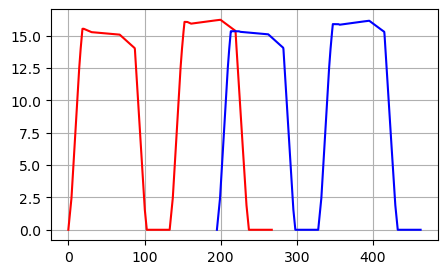

In [32]:

""" 
ds = 5m
x1,x2 => L6 [10785 m, 12065 m] => idx: [2174, 2270, 2374, 2432] 站点-Tr结束点-Cr结束点-站点
x3,x4 => L7 [12065 m, 13419 m] => idx: [2432, 2526, 2646, 2705]

ds = 10m
x1,x2 => L6 [10785 m, 12065 m] => idx: [1097, 1145, 1195, 1226]
x3,x4 => L7 [12065 m, 13419 m] => idx: [1226, 1274, 1331, 1363]
"""
station = [6, 7, 8]

# DBO参数设置
pop = 50
p_percent = 0.2
max_iter = 200
dim = 4
fun = fitnessFun

if dim == 4:
    ub = [2270,              2374,              2526,              2646         ]
    lb = [station_idx[6]+5, station_idx[6]+5, station_idx[7]+5, station_idx[7]+5]
elif dim == 6:
    ub = [2270,             2374,             station_idx[7]-10, 2526,             2646,             station_idx[8]-10]
    lb = [station_idx[6]+3, station_idx[6]+5, station_idx[6]+5,  station_idx[7]+3, station_idx[7]+5, station_idx[7]+5 ]
elif dim == 8:
    ub = [2270,             2364,             2374,              station_idx[7]-10, 2526,             2636,             2646,             station_idx[8]-10]
    lb = [station_idx[6]+3, station_idx[6]+3, station_idx[6]+5,  station_idx[6]+5,  station_idx[7]+3, station_idx[7]+5, station_idx[7]+5, station_idx[7]+5 ]

# 仿真开始
combined_list = list(range(0, 7)) + list(range(26, 30))
# for t in combined_list:
for t in [26]:
    departure_interval = 65 + t*5
    train2 = Train()
    start_time = datetime.now()
    X, gfitness, gbest, record_gfitness = DBO(p_percent, pop, dim, max_iter, lb, ub, fun, station, train_p, train2, departure_interval)
    end_time = datetime.now()
    print("DBO消耗时间: ", (end_time - start_time).total_seconds(), "秒")

    # 代入最优值
    xlist = gbest
    train2 = Train()
    train2 = coordTrip(xlist, station, train2, departure_interval, 1, 2, dim)
    train_f.t = column_data4[f't {case}'].dropna().tolist()
    for i in range(len(train_f.t)):
        train_f.t[i] += departure_interval

    # 能耗
    ree_12, ree_all_12 = reE(RE_EFF, train_p, train2, departure_interval)
    alle_12 = train_p.e[-1] + train2.e[-1]
    reale_12 = (alle_12 -ree_12)
    ree_13, ree_all_13 = reE(RE_EFF, train_p, train_f, departure_interval)
    alle_13 = 2*train_p.e[-1]
    reale_13 = (alle_13 -ree_13)
    delta_ree = ree_12 - ree_13
    delta_e = reale_12 - reale_13

    # 运行时间
    t_error_L6 = (train2.arrival_time[0]-op_time[6]-departure_interval)
    t_error_L7 = (train2.arrival_time[1]-op_time[6]-op_time[7]-dw_time[6]-departure_interval)

    print(f"[ departure_interval: {departure_interval} s]" )
    print(f'[ 最优值为：{gfitness:.6f} ]')
    print(f'[ 最优变量为：{gbest} ]')
    print(f"[ 运行能耗：{train_p.e[-1]:.3f} J, {train2.e[-1]:.3f} J, {(train_p.e[-1]+train2.e[-1]):.3f} J]")
    print(f"[ train2: L6到站时间: {train2.arrival_time[0]:.3f} s, 误点率：{t_error_L6:.3f} s; L7到站时间: {train2.arrival_time[1]:.3f} s, 误点率：{t_error_L7:.3f} s]")
    print(f'[ 总能耗: {alle_12:.3f}, 再生制动利用: {ree_12:.3f}, 再生制动总能耗: {ree_all_12:.3f}, 真实能耗: {reale_12:.3f} ]')
    print(f'[ 再生制动利用提升: {delta_ree:.3f}, 能耗降低: {delta_e:.3f}]')
    print("")
    plt.figure(figsize=(5, 3))
    plt.plot(train_p.t, train_p.v, 'r')
    plt.plot(train2.t, train2.v, 'b')
    plt.grid()

    results = ()
    results = ("departure_interval", departure_interval, "gfitness", gfitness, "gbest", gbest, 
                "t_error_L6", t_error_L6, "t_error_L7", t_error_L7,
                "alle_12", alle_12, "ree_12", ree_12, "real_e_12", reale_12, "alle_13", alle_13, "ree_13", ree_13,  "reale_13", reale_13,
                "delta_re_e", delta_ree, "delta_real_e", delta_e,
                "record_gfitness")

    # 将字典转换为pandas DataFrame
    df_1 = pd.DataFrame(results, columns=[f'Column{t+1}'])
    df_2 = pd.DataFrame(record_gfitness, columns=[f'Column{t+1}'])
    df_1 = pd.concat([df_1, df_2], ignore_index=True)

    # 指定Excel文件名和sheet名
    excel_filepath = 'D:\Python\Jupyter_Code\CASCO\paper2\\results\\tcco_tacs_5_4_DBO.xlsx' 

    # 如果是第一次循环，直接将新数据写入Excel文件
    if case == 0: 
        df_1.to_excel(excel_filepath, index=False)
    else:
        df_existing = pd.read_excel(excel_filepath)
        df_existing = pd.concat([df_existing, df_1], axis=1)
        df_existing.to_excel(excel_filepath, index=False)

[ departure_interval: 65 s]
[ 最优值为：29.339307 ]
[ 最优变量为：[2195 2196 2204 2205 2464 2471 2471 2471] ]
[ train2: L6到站时间: 167.304 s, 误点率：-0.696 s; L7到站时间: 302.387 s, 误点率：0.387 s]
[ 运行能耗：20.189 J, 23.556 J, 43.745 J]
[ 再生制动利用: 14.723, 再生制动总能耗: 16.567, 真实能耗: 29.022 ]
[ 再生制动利用提升: 14.651, 能耗降低: -11.284]


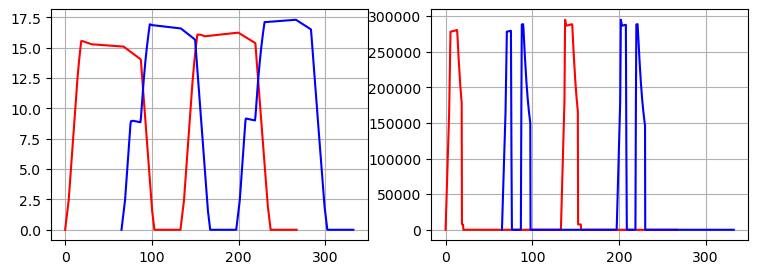

In [28]:
""" 生成运行曲线 """
dim = 8
departure_interval = 65

# gbest = [2204, 2210, 2462, 2483]
gbest = [2182, 2203, 2232, 2232, 2441, 2461, 2491, 2491]

fitness = fitnessFun(gbest, dim, station, train_p, train2, departure_interval)
train2 = Train()
train2 = coordTrip(gbest, station, train2, departure_interval, 1, 2, dim)
train_f.t = column_data4[f't {case}'].dropna().tolist()
for i in range(len(train_f.t)):
    train_f.t[i] += departure_interval

# 能耗
ree_12, ree_all_12 = reE(RE_EFF, train_p, train2, departure_interval)
alle_12 = train_p.e[-1] + train2.e[-1]
reale_12 = (alle_12 -ree_12)
ree_13, ree_all_13 = reE(RE_EFF, train_p, train_f, departure_interval)
alle_13 = 2*train_p.e[-1]
reale_13 = (alle_13 -ree_13)
delta_ree = ree_12 - ree_13
delta_e = reale_12 - reale_13
# 运行时间
t_error_L6 = (train2.arrival_time[0]-op_time[6]-departure_interval)
t_error_L7 = (train2.arrival_time[1]-op_time[6]-op_time[7]-dw_time[6]-departure_interval)
print(f"[ departure_interval: {departure_interval} s]" )
print(f'[ 最优值为：{fitness:.6f} ]')
print(f'[ 最优变量为：{xlist} ]')
print(f"[ train2: L6到站时间: {train2.arrival_time[0]:.3f} s, 误点率：{t_error_L6:.3f} s; L7到站时间: {train2.arrival_time[1]:.3f} s, 误点率：{t_error_L7:.3f} s]")
print(f"[ 运行能耗：{train_p.e[-1]:.3f} J, {train2.e[-1]:.3f} J, {alle_12:.3f} J]")
print(f'[ 再生制动利用: {ree_12:.3f}, 再生制动总能耗: {ree_all_12:.3f}, 真实能耗: {reale_12:.3f} ]')
print(f'[ 再生制动利用提升: {delta_ree:.3f}, 能耗降低: {delta_e:.3f}]')
plt.figure(figsize=(9, 3))
plt.subplot(1,2,1) 
plt.plot(train_p.t, train_p.v, 'r')
plt.plot(train2.t, train2.v, 'b')
plt.grid()
plt.subplot(1,2,2)
plt.plot(train_p.t, train_p.f_t, 'r')
plt.plot(train2.t, train2.f_t, 'b')
plt.grid()

In [ ]:
""" 存储追踪列车运行曲线 """
i = 1
column_names = [f'state {i}', f't {i}', f's {i}', f'v {i}', f'a {i}', f'f_t {i}', f'f_b {i}', f'e {i}']
data = {column_names[0]: train2.state,
        column_names[1]: train2.t,
        column_names[2]: train2.s,
        column_names[3]: train2.v,
        column_names[4]: train2.a,
        column_names[5]: train2.f_t,
        column_names[6]: train2.f_b,
        column_names[7]: train2.e}

excel_filepath = 'D:\Python\Jupyter_Code\CASCO\paper2\\results\\train2_operation_5_6.xlsx'
excelTools.dfStorage(data, excel_filepath, {i})

successful storage in D:\Python\Jupyter_Code\CASCO\paper2\results\train2_operation_5_6.xlsx


In [33]:
excel_filepath = 'D:\Python\Jupyter_Code\CASCO\paper2\\results\\tcco_tacs_5_4_DBO.xlsx' 
excelTools.fontSet(excel_filepath)

In [ ]:
""" CBTC 能耗计算 """
for j in range(34):
# for j in [4]:
        departure_interval = 65+j*5
        train_f.t = column_data4['t 1'].dropna().tolist()
        for i in range(len(train_f.t)):
                train_f.t[i] += departure_interval
        ree_12, ree_all_12 = reE(RE_EFF, train_p, train_f, departure_interval)
        alle_12 = train_p.e[-1] + train_f.e[-1]
        reale_12 = (alle_12 -ree_12)
        print(f'departure_interval: {departure_interval} s, 总能耗: {alle_12:.3f}, 再生制动利用能耗: {ree_12:.3f}, 再生制动能耗: {ree_all_12:.3f},真实能耗: {reale_12:.3f}')

# plt.subplot(1,2,1)
# plt.plot(train_p.t, train_p.v, 'r')
# plt.plot(train_f.t, train_f.v, 'b')
# plt.subplot(1,2,2)
# plt.plot(train_p.t, train_p.state, 'r')
# plt.plot(train_f.t, train_f.state, 'b')